# Calculating Subsitute Geographic Coordinates

My early attempts to study the problem suggested that longitude and latitude were among the most important features for determining the pump status. But it also appeared that a nontrivial fraction of pumps (1,812 out of 59,400) had a default value of 0,0 for these fields. Here I demonstrate the issue, and develop a method for approximating the location of the pump from fields that provide regional information.

In [1]:
import pandas as pd
import numpy as np
from load_data import load_data
from haversine import haversine

train_df=load_data("training").assign(subsample="Training").drop("status_group", axis=1)
test_df=load_data("testing").assign(subsample="Testing")

combined_df=pd.concat([train_df, test_df])

Load data, training
Load data, testing


## Documenting the problem

Let's make simple scatter plots of laititude vs longitude.  Note what appears to be a single point at 0,0.  Then let's filter that out by requiring longitiude > 10, and see that things look much more reasonable.  We also check show that there is only one unique value for the coordinates that fail this constraint.  Finally we determine how often this happens, which turns out to be about 3% of the time.

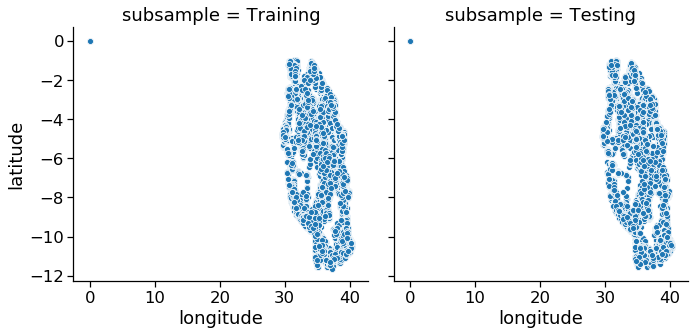

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3})

sns.relplot(data=combined_df, x="longitude", y="latitude", col="subsample")

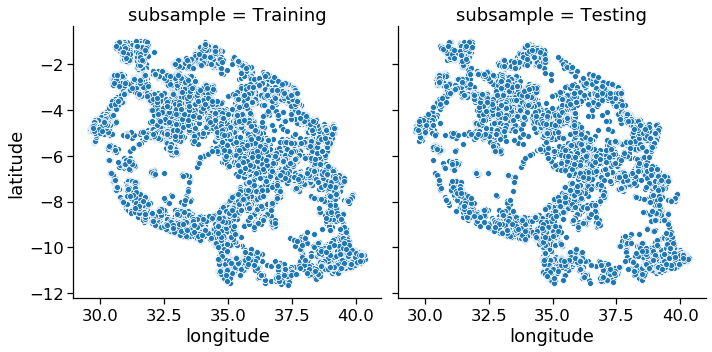

In [3]:
sns.relplot(data=combined_df.query("longitude>10"), x="longitude", y="latitude", col="subsample")

In [4]:
combined_df[["latitude","longitude"]].query("longitude<10").drop_duplicates()

,latitude,longitude
21,-2.000000e-08,0.0


In [5]:
def calc_coord_validity(r):
    if r.longitude<10:
        return "Invalid coordinates"
    else:
        return "Valid coordinates"
    
combined_df["valid_coords"]=combined_df.apply(calc_coord_validity,axis=1)
coord_validity_summary=combined_df.pivot_table(index="valid_coords", columns="subsample", values="id", aggfunc="count").\
                       reset_index()
coord_validity_summary["Testing %"]=100*coord_validity_summary.Testing/coord_validity_summary.Testing.sum()
coord_validity_summary["Training %"]=100*coord_validity_summary.Training/coord_validity_summary.Training.sum()
coord_validity_summary

subsample,valid_coords,Testing,Training,Testing %,Training %
0,Invalid coordinates,457,1812,3.077441,3.050505
1,Valid coordinates,14393,57588,96.922559,96.949495


## Towards a Solution

The basic strategy to deal with the missing coordinate data is to look at categorical fields that correspond to specific geographic areas. For example, all the pumps in a subvillage should all be pretty close together. But you has to be careful.  You can have multiple towns in with the same name but in different regions (think how many states have a city named "Bloomington"). In that case we would look for matches in several fields at once. First we split the data acocrding to whether or not we have valid coordinates and look at the geographical fields to see how often we can find a match for a given set of fields.

In [6]:
missing_df   = combined_df.query('valid_coords=="Invalid coordinates"')
reference_df = combined_df.query('valid_coords=="Valid coordinates"')

In [7]:
def check_missing_coords(regional_level):
    all_values=combined_df[regional_level].unique()
    missing_regions=missing_df[[regional_level]].drop_duplicates()
    reference_matches=reference_df[[regional_level]].merge(missing_regions, on=regional_level).drop_duplicates()
    results = dict()
    results['Regional level'] = regional_level
    results[         'Total'] = all_values.shape[0]
    results[       'Missing'] = missing_regions.shape[0]
    results[     'Has match'] = reference_matches.shape[0]
    return pd.Series(results)

regional_levels=["basin", "district_code","region","region_code","lga","ward","subvillage"]

pd.DataFrame([check_missing_coords(rl) for rl in regional_levels]).sort_values("Total")

,Regional level,Total,Missing,Has match
0,basin,9,2,2
1,district_code,20,4,4
2,region,21,2,2
3,region_code,27,3,3
4,lga,125,3,2
5,ward,2098,69,10
6,subvillage,21426,1069,261


The above table requires some interpration.  It says that pumps are found in (for example) 2098 separate wards, but that in 69 of those wards, there is at least one pump with no valid lattiude/longitude coordinates.  Of those 69 wards, 10 have at least one other pump that **does** have valid coordinates.  There are two conclusions to draw from this table:

1. At least in a rough sense, we are are likely to need to go at least to the LGA (Local Gov't Authority) level to find proxy geographic information for a sizeable fraction of the cases where we need it.
2. The highest up the location hierachy we need to go is to the region_code level.  But depending on how the regional specifications overlap, there may still be value there.

In [8]:
def calc_precision(row):
    p1=(row.latitude_mean,
        row.longitude_mean)
    p2=(row.latitude_mean + row.latitude_std,
        row.longitude_mean + row.longitude_std)

    return haversine(p1,p2) #default return unit is km

def make_map(region_specifier):
    geo_map=reference_df.groupby(region_specifier).\
                   agg(npumps=("id","count"),
                       latitude_mean=("latitude","mean"),
                       longitude_mean=("longitude","mean"),
                       latitude_std=("latitude","std"),
                       longitude_std=("longitude","std")).\
                   reset_index()
    
    geo_map["precision"]   = geo_map.apply(calc_precision, axis=1)
    geo_map["proxy_level"] = "/".join(region_specifier)
    return geo_map

def check_matches(region_specifier):
    ref_map = make_map(region_specifier)
    found=missing_df.merge(ref_map,on=region_specifier)
    
    results=dict()
    results[     "Specifier"] = "/".join(region_specifier)
    results[       "Missing"] = missing_df.shape[0]
    results[       "Matches"] = found.shape[0]
    results[    "w/ >1 pump"] = found.query("npumps>1").shape[0]
    results[    "w/ >2 pump"] = found.query("npumps>2").shape[0]
    results[       "Lat Std"] = found.query("npumps>1").latitude_std.mean()
    results[       "Lon Std"] = found.query("npumps>1").longitude_std.mean()
    results[ "Avg Precision"] = found.query("npumps>1").precision.mean()
    return pd.Series(results)

Let's look for proxies at the most granular level available, the subvillage. We start by looking for matches on lots of fields, and then try relaxing those constraints.  Some observations:

1. Matching at region_code/ward/subvillage level we can get very precise (less than a mile precision), but only for very few pumps.
2. Whether or not we specify the basin doesn't matter to anything.
3. If we specify just one of the region code or district code, nothing changes
4. Removing both the region and district codes does appear to make a big difference
5. Removing the ward information does make a big difference.

In [9]:
region_specifiers=[["basin","district_code","region_code","ward","subvillage"],

                   ["district_code","region_code","ward","subvillage"],
                   
                   ["district_code","ward","subvillage"],
                   ["region_code","ward","subvillage"],                   
                   ["district_code","region_code","subvillage"],

                   ["ward","subvillage"],
                   ["region_code","subvillage"],                   
                   ["district_code","subvillage"]]

pd.DataFrame([check_matches(rs) for rs in region_specifiers])

,Specifier,Missing,Matches,w/ >1 pump,w/ >2 pump,Lat Std,Lon Std,Avg Precision
0,basin/district_code/region_code/ward/subvillage,2269,5,3,1,0.001813,0.005122,0.607557
1,district_code/region_code/ward/subvillage,2269,5,3,1,0.001813,0.005122,0.607557
2,district_code/ward/subvillage,2269,5,3,1,0.001813,0.005122,0.607557
3,region_code/ward/subvillage,2269,5,3,1,0.001813,0.005122,0.607557
4,district_code/region_code/subvillage,2269,168,147,128,0.021190,0.037428,5.099870
5,ward/subvillage,2269,25,23,21,0.019405,0.017983,2.951959
6,region_code/subvillage,2269,558,465,399,0.155945,0.280425,37.270206
7,district_code/subvillage,2269,438,372,340,1.343145,1.192663,203.046212


Now let's do the same excercise, but using the ward as our most granular level.  Again, we find that we don't really need to think about the basin.  We also find:
1. If we specify the LGA, we only need one of the district or region codes
2. Interestingly, we can get better precision if we match on just district code/ward than for some of the more detailed matches.  This needs further investigation, but strikes me as an artifact.  I would still prefer the more tightly specified case.

In [10]:
region_specifiers=[["basin","region_code","district_code","lga","ward"],
                   
                   ["region_code","district_code","lga","ward"],

                   ["region_code","lga","ward"],                   
                   ["district_code","lga","ward"],
                   ["region_code","district_code","ward"],

                   ["region_code","ward"],
                   ["district_code","ward"],
                   ["lga","ward"],
                   
                   ["ward"]]

pd.DataFrame([check_matches(rs) for rs in region_specifiers])


,Specifier,Missing,Matches,w/ >1 pump,w/ >2 pump,Lat Std,Lon Std,Avg Precision
0,basin/region_code/district_code/lga/ward,2269,169,169,169,0.025576,0.029942,4.517878
1,region_code/district_code/lga/ward,2269,169,169,169,0.025576,0.029942,4.517878
2,region_code/lga/ward,2269,169,169,169,0.025576,0.029942,4.517878
3,district_code/lga/ward,2269,169,169,169,0.025576,0.029942,4.517878
4,region_code/district_code/ward,2269,169,169,169,0.025576,0.029942,4.517878
5,region_code/ward,2269,169,169,169,0.113723,0.069912,15.065785
6,district_code/ward,2269,269,269,269,0.016395,0.019758,2.949688
7,lga/ward,2269,243,243,243,0.034961,0.080045,9.996472
8,ward,2269,457,457,457,0.082610,0.072301,13.210139


We go another step up for out most granular specifications: to the Local Gov't Authority.  We find that very little we do seems to make much difference, but we should probably be more specific than just matching on the LGA.

In [11]:
region_specifiers=[["basin","region_code","district_code","lga"],
                   
                   ["region_code","district_code","lga",],

                   ["region_code","lga"],                   
                   ["district_code","lga"],

                   ["lga"]]

pd.DataFrame([check_matches(rs) for rs in region_specifiers])


,Specifier,Missing,Matches,w/ >1 pump,w/ >2 pump,Lat Std,Lon Std,Avg Precision
0,basin/region_code/district_code/lga,2269,1589,1589,1589,0.053492,0.139551,16.602978
1,region_code/district_code/lga,2269,1589,1589,1589,0.053492,0.139551,16.602978
2,region_code/lga,2269,1589,1589,1589,0.053977,0.142702,16.947811
3,district_code/lga,2269,1589,1589,1589,0.053492,0.139551,16.602978
4,lga,2269,1666,1666,1666,0.055488,0.146311,17.382493


We continue to step up the ladder.  Here the basin does seem to make a difference, and now we can match them all.  However, it appears to make no sense to just specify the district.

In [12]:
region_specifiers=[["basin","region_code","district_code"],
                   ["region_code"],
                   ["district_code"],
                   ["region"]]

pd.DataFrame([check_matches(rs) for rs in region_specifiers])


,Specifier,Missing,Matches,w/ >1 pump,w/ >2 pump,Lat Std,Lon Std,Avg Precision
0,basin/region_code/district_code,2269,1661,1661,1661,0.052057,0.141856,16.791800
1,region_code,2269,2269,2269,2269,0.328697,0.582813,75.471459
2,district_code,2269,2269,2269,2269,2.490890,2.614703,402.081996
3,region,2269,2269,2269,2269,0.330097,0.569917,74.307495


## Calculating approximate coordinates

Let's now choose a hierarchy of regional specifiers and see how we are doing in more detail.  From each of the above groupings, we choose one.  At the subvillage granularity, there are several choices that offer sub-mile precision, but with few matches, most of which only have one pump per match. In those cases, the precision (measured from the standard deviation) is probably not reliable.  So we pick the **ward/subvillage** specifier.  At ward-level granularity,  the clear choice seems to be the **district_code/ward** specification.  At the LGA level, all options are roughly equivalent, so we pick 
**region_code/district_code/lga**.  Finally at the most coarse level, the first option seems to offer no improvement over the LGA level.  Of the remainder, we choose **region** as ogfering slightly better performance.

Then we will drop some of these candidate levels and see if that makes a susbtantial difference.

In [13]:
def get_keys(m):
    data_fields=["npumps","precision","longitude_mean","longitude_std","latitude_mean","latitude_std", "proxy_level"]
    keys = [c for c in m.columns if c not in data_fields]
    return keys

def calc_approx_coords(pump, geo_maps):
    
    pump=pd.DataFrame(pump).transpose()
    best_match=None
    for m in geo_maps:
        keys=get_keys(m)
        match=pump.merge(m,on=keys)
        if match.shape[0]>1:
            print ("ERROR multiple matches for ", keys)
        elif match.shape[0]==0:
            continue
        match=match.loc[0]
        
        if best_match is None:
            best_match=match
        elif match.precision < best_match.precision:
            best_match=match
            
    result_cols=["id","latitude_mean","longitude_mean","precision", "proxy_level"]
    rename_map={"latitude_mean":"approx_latitude",
                "longitude_mean":"approx_longitude",
                "precision":"loc_precision"}
    results=best_match[result_cols] #.rename(rename_map)
    return results
            
def summarize_precision(ac):
    summary=ac.groupby("proxy_level").\
               agg(count=("id","count"),
                   precision_avg=("precision","mean"),
                   precision_std=("precision","std")).\
               sort_values("precision_avg").\
               reset_index()
    
    fg=sns.FacetGrid(data=approx_coords, hue="proxy_level", height=5, aspect=1.5)
    fg.map(sns.distplot,"precision",
           kde=False,
           bins=np.linspace(0.0,60.0,30),
           hist_kws={"histtype": "step","linewidth": 3,"alpha": 1})
    fg.set(xlabel="Precision (miles)",ylabel=("Pumps"))
    fg.add_legend()
    display(summary)

,proxy_level,count,precision_avg,precision_std
0,district_code/ward,264,2.892434,2.415852
1,ward/subvillage,25,2.951959,2.104743
2,region_code/district_code/lga,1314,17.051951,4.919181
3,region_code,666,55.703603,11.880669


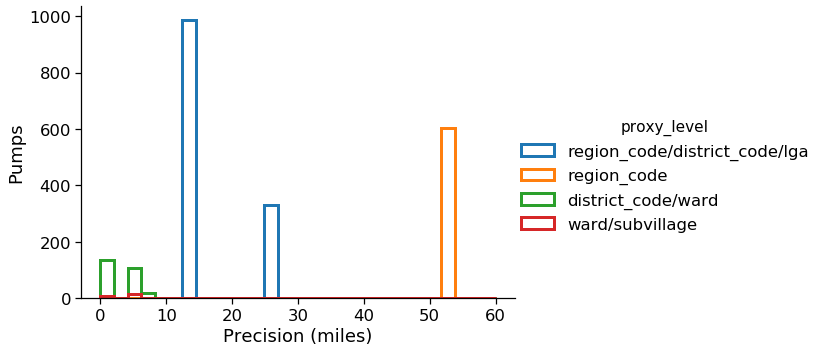

In [14]:
candidate_specifiers=[["ward","subvillage"],
                      ["district_code", "ward"],
                      ["region_code", "district_code", "lga"],
                      ["region_code"]]
geo_maps=[make_map(cs) for cs in candidate_specifiers]

approx_coords=missing_df.apply(lambda x: calc_approx_coords(x, geo_maps),axis=1)
summarize_precision(approx_coords)